In [2]:
from src.Distributions import *
from collections import Counter
from multiprocessing import Pool
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
from matplotlib.ticker import MultipleLocator, AutoMinorLocator, FormatStrFormatter, ScalarFormatter, LogLocator, LogFormatterSciNotation
import matplotlib.lines as mlines
from itertools import cycle
from IPython.display import clear_output
plt.style.use('properties.mplstyle')
from matplotlib.ticker import LogLocator, LogFormatterMathtext


In [12]:
make_results_folders()

In [2]:
N = 10**5
m0 = 2
# Generate .npy with all degree and distances values from gml.gz files
degree_file_filter(N, m0)
distance_file_filter(N, m0)
clear_output() 


In [3]:
N  = 10**5
m0 = 2
alpha_ag_f = 2.0
alpha_g_v = [2.0, 3.0, 4.0, 5.0]
alpha_a_v = [1.0, 2.0, 3.0, 4.0, 5.0]
dim = [1,2,3,4]
# Generate .npy with all degree values from gml.gz files
bin_count = 40
for d in dim:
    for aa in alpha_a_v:    
        print(f"N = {N}, dim = {d}, α_A = {aa:.2f}, α_G = {alpha_ag_f:.2f}")
        try:
            # Generate log_binning file to distances and degree
            dados = np.load(f"../../data/N_{N}/m0_{m0}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_ag_f:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
            dados_flat = dados.flatten()
            log_binning_distances(dados_flat, bin_count, save=True, N=N, m0=m0 ,dim=d, alpha_a=aa, alpha_g=alpha_ag_f)
            
            dados = np.load(f"../../data/N_{N}/m0_{m0}/dim_{d}/alpha_a_{aa:.2f}_alpha_g_{alpha_ag_f:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
            dados_flat = dados.flatten()
            log_binning(Counter(dados_flat), bin_count, save=True, N=N,m0=m0, dim=d, alpha_a=aa, alpha_g=alpha_ag_f)

            # Generate linear binning to degree
            distribution(dados_flat, save=True, N=N, m0=m0, dim=d, alpha_a=aa, alpha_g=alpha_ag_f)
        except FileNotFoundError: 
            print("not file")
            pass
    print("-----------------")
    for ag in alpha_g_v:
        print(f"N = {N}, dim = {d}, α_A = {alpha_ag_f:.2f}, α_G = {ag:.2f}")
        try:
            # Generate log_binning file to distances and degree
            dados = np.load(f"../../data/N_{N}/m0_{m0}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{ag:.2f}/distances.npy")  # Shape (n_arquivos, n_linhas)
            dados_flat = dados.flatten()
            log_binning_distances(dados_flat, bin_count, save=True, N=N, m0=m0 ,dim=d, alpha_a=alpha_ag_f, alpha_g=ag)
            
            dados = np.load(f"../../data/N_{N}/m0_{m0}/dim_{d}/alpha_a_{alpha_ag_f:.2f}_alpha_g_{ag:.2f}/degree.npy")  # Shape (n_arquivos, n_linhas)
            dados_flat = dados.flatten()
            log_binning(Counter(dados_flat), bin_count, save=True, N=N, m0=m0 ,dim=d, alpha_a=alpha_ag_f, alpha_g=ag)

            # Generate linear binning to degree
            distribution(dados_flat, save=True, N=N, m0=m0, dim=d, alpha_a=alpha_ag_f, alpha_g=ag)
        except FileNotFoundError: 
            print("not file")
            pass
clear_output()

In [ ]:
#folder_path = "../../data"
#delete_files_in_gml_folders(folder_path)

In [3]:
N = 10**5
m0 = 2
dim = [1, 2, 3, 4]
alpha_g_v = [2.0, 3.0, 4.0, 5.0]
alpha_a_v = [1.0, 2.0, 3.0, 4.0, 5.0]
save_json_distributions(N, m0, dim, alpha_a_v, alpha_g_v)

Arquivo '../../data/N_100000/m0_2/distances_distributions.json' salvo com sucesso.
Arquivo '../../data/N_100000/m0_2/degree_distributions.json' salvo com sucesso.


In [9]:
# read json of degree and converter to DataFrame Pandas
df_degree = json_to_dataframe_with_lists(f'../../data/N_{N}/m0_{m0}/degree_distributions.json')
# read json of degree and converter to DataFrame Pandas
df_distances = json_to_dataframe_with_lists(f'../../data/N_{N}/m0_{m0}/distances_distributions.json')
df_degree.head()

,N,alpha_A,alpha_G,dim,N_s,k,Pk
0,100000,2.0,2.0,1,133,"[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, ...","[0.4012892481203006, 0.2116098496240601, 0.124..."
1,100000,2.0,3.0,1,132,"[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, ...","[0.4010531818181818, 0.2116741666666666, 0.124..."
2,100000,2.0,4.0,1,133,"[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, ...","[0.4011048120300752, 0.2115812781954887, 0.124..."
3,100000,2.0,5.0,1,133,"[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, ...","[0.4010945454545455, 0.2116490909090909, 0.124..."
4,100000,1.0,2.0,1,133,"[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, ...","[0.4886878947368421, 0.19947992481203, 0.10163..."


In [5]:
df_distances.head()

,N,alpha_A,alpha_G,dim,N_s,deltaS,pdeltaS
0,100000,2.0,2.0,1,133,"[7.955400507645009e-07, 1.428412905150881e-06,...","[0.1635551797942543, 0.1621928724105278, 0.157..."
1,100000,2.0,3.0,1,132,"[6.571581327211588e-07, 1.0890083059239654e-06...","[0.1611956117967736, 0.1586491967832212, 0.151..."
2,100000,2.0,4.0,1,133,"[5.753277274511796e-07, 9.063286311481204e-07,...","[0.1589237760877927, 0.155358309206636, 0.1480..."
3,100000,2.0,5.0,1,133,"[5.609300247598979e-07, 8.755714810458936e-07,...","[0.1682146124819676, 0.1625736394587625, 0.151..."
4,100000,1.0,2.0,1,133,"[7.771194222742143e-07, 1.3810326926055942e-06...","[0.2413573096556159, 0.2059996971637884, 0.165..."


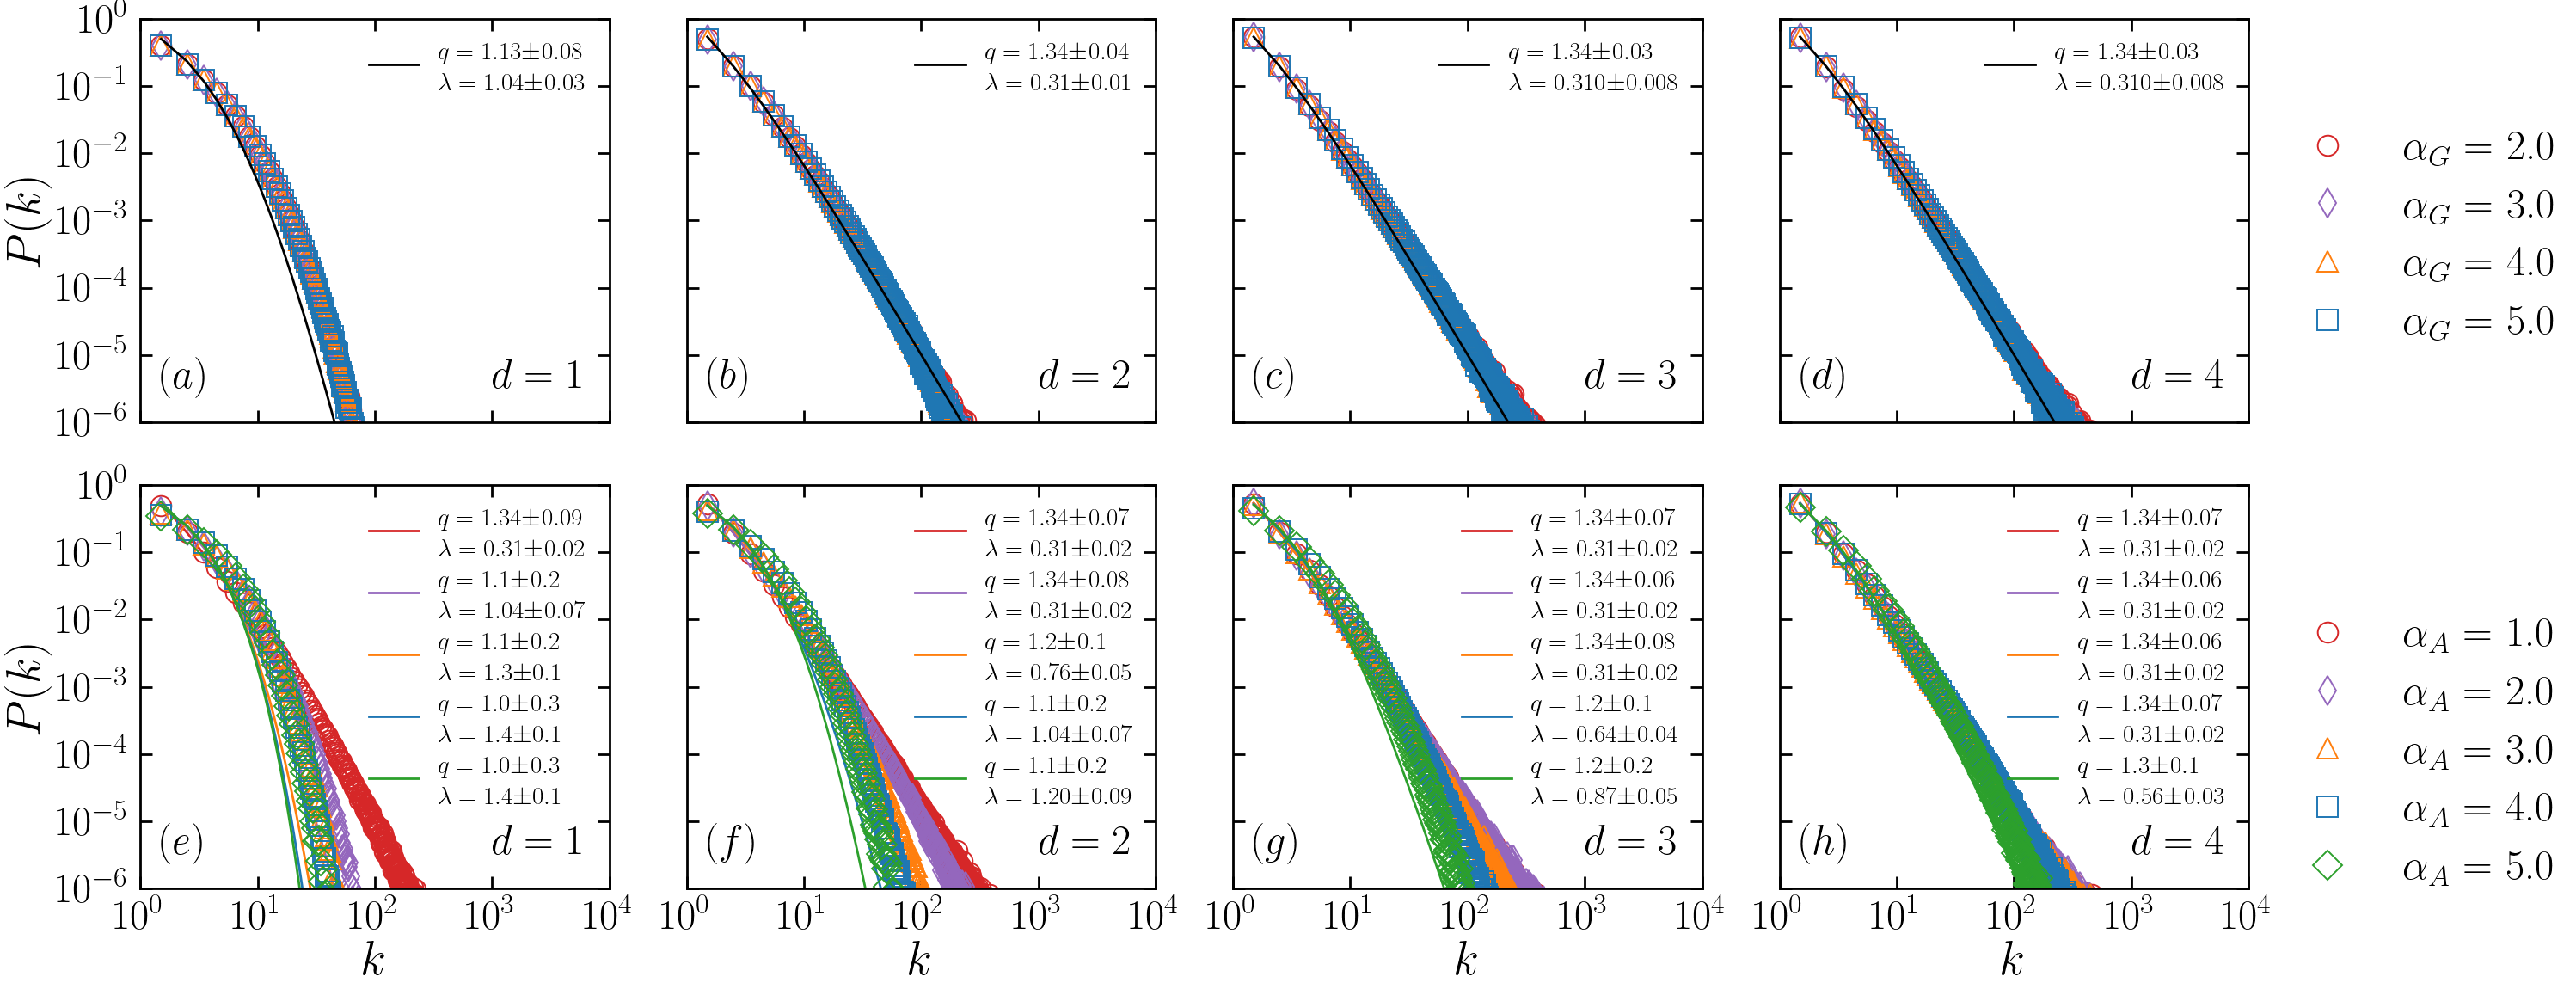

In [13]:
plt.style.use('./properties.mplstyle')
plt.rcParams.update({
    "text.latex.preamble": r"\usepackage{amsmath}"
})
plt.rcParams["text.usetex"] = True
plt.rcParams["font.family"] = "serif"

def round_value_and_error(value, error):
    """
    Arredonda o valor e o erro seguindo notação científica padrão:
    - Erro com 1 dígito significativo (ou 2 se começar com 1).
    - Valor arredondado para a mesma precisão decimal do erro.
    Retorna string: "valor ± erro"
    """
    if error == 0 or np.isnan(error):
        return f"{value:.4f} $±$ {error:.4f}"

    # Dígito mais significativo do erro
    exponent = int(np.floor(np.log10(abs(error))))
    mantissa = error / 10**exponent

    # Arredonda erro para 1 ou 2 dígitos significativos
    if mantissa < 1.5:
        sig_figs = 2
    else:
        sig_figs = 1

    rounded_error = round(error, -exponent + sig_figs - 1)

    # Número de casas decimais para o valor central
    decimals = max(-int(np.floor(np.log10(rounded_error))), 0)
    rounded_value = round(value, decimals)

    fmt = f".{decimals}f"
    return f"{format(rounded_value, fmt)} \\displaystyle{{\\pm}} {format(rounded_error, fmt)}"

# ✔️ Criando figura 2x4

N = 10**5
m0 = 2
dim = [1, 2, 3, 4]
alpha_g_v = [2.0, 3.0, 4.0, 5.0]
alpha_a_v = [1.0, 2.0, 3.0, 4.0, 5.0]
alpha_ag_f = 2.0

# Alpha_A fixo em 2.0, Alpha_G variando
k_1d_g, pk_1d_g = get_k_pk_from_dataframe(df_degree, dim=1, fixed_param='alpha_A', fixed_value=2.0, varying_param_list=alpha_g_v)
k_2d_g, pk_2d_g = get_k_pk_from_dataframe(df_degree, dim=2, fixed_param='alpha_A', fixed_value=2.0, varying_param_list=alpha_g_v)
k_3d_g, pk_3d_g = get_k_pk_from_dataframe(df_degree, dim=3, fixed_param='alpha_A', fixed_value=2.0, varying_param_list=alpha_g_v)
k_4d_g, pk_4d_g = get_k_pk_from_dataframe(df_degree, dim=4, fixed_param='alpha_A', fixed_value=2.0, varying_param_list=alpha_g_v)

q_1d, err_1d_q, b_1d, err_1d_b = combine_estimates_from_datasets(k_1d_g, pk_1d_g, dim = 1)
q_2d, err_2d_q ,b_2d, err_2d_b = combine_estimates_from_datasets(k_2d_g, pk_2d_g, dim = 2)
q_3d, err_3d_q, b_3d, err_3d_b = combine_estimates_from_datasets(k_3d_g, pk_3d_g, dim = 3)
q_4d, err_4d_q, b_4d, err_4d_b = combine_estimates_from_datasets(k_4d_g, pk_4d_g, dim = 4)

Q, Q_err, B, B_err = [q_1d, q_2d, q_3d, q_4d], [err_1d_q, err_2d_q, err_3d_q, err_4d_q], [b_1d, b_2d, b_3d, b_4d], [err_1d_b, err_2d_b, err_3d_b, err_4d_b]

# ✔️ Ler os JSONs convertidos em DataFrames
df_degree = json_to_dataframe_with_lists(f'../../data/N_{N}/m0_{m0}/degree_distributions.json')
df_distances = json_to_dataframe_with_lists(f'../../data/N_{N}/m0_{m0}/distances_distributions.json')

label_1d = f'$q =  {q_1d:.2f} \\pm {err_1d_q:.2f}, \\lambda = {b_1d:.2f} \\pm {err_1d_b:.2f}$'
label_2d = f'$q = {q_2d:.1f} \\pm {err_2d_q:.2f}, \\lambda = {b_2d:.2f} \\pm {err_2d_b:.2f}$'
label_3d = f'$q = {q_3d:.2f} \\pm {err_3d_q:.2f}, \\lambda = {b_3d:.2f} \\pm {err_3d_b:.2f}$'
label_4d = f'$q = {q_4d:.2f} \\pm {err_4d_q:.2f}, \\lambda = {b_4d:.2f} \\pm {err_4d_b:.2f}$'

labels = [label_1d, label_2d, label_3d, label_4d]

# ✔️ Configurações visuais
color = ["#d62728", "#9467bd", '#ff7f0e', "#1f77b4", "#2ca02c", "darkgoldenrod"]
markers = ["o", "d", "^", "s", "D", "v"]
markersize = 17
thickness_axes = 2.0
font_size_labels = 40
ticks_label_size = 35
legend_size = 21
mew = 1.4
dim_list = [1, 2, 3, 4]

labels_tick = ["$(a)$", "$(b)$", "$(c)$", "$(d)$", "$(e)$", "$(f)$", "$(g)$", "$(h)$"]

df_degree_filter_alpha_g = df_degree[
    (df_degree['alpha_A'].isin([alpha_ag_f])) & 
    (df_degree['alpha_G'].isin(alpha_g_v))
]

# Para plot de baixo
df_degree_filter_alpha_a = df_degree[
    (df_degree['alpha_G'] == alpha_ag_f) & 
    (df_degree['alpha_A'].isin(alpha_a_v))
]

labels_global_alpha_g = [rf"$\alpha_G$ = {a:.1f}" for a in alpha_g_v]
labels_global_alpha_a = [rf"$\alpha_A$ = {a:.1f}" for a in alpha_a_v]

fig, ax = plt.subplots(2, 4, figsize=(30, 12))

# =====================================
# ✔️ PLOT DE CIMA (Alpha_A fixo, Alpha_G variando)
# =====================================
for idx, d in enumerate(dim_list):
    row, col = 0, idx
    df_dim = df_degree_filter_alpha_g[df_degree_filter_alpha_g['dim'] == d]

    for i, alpha_g in enumerate(alpha_g_v):
        df_alpha = df_dim[df_dim['alpha_G'] == alpha_g]

        if not df_alpha.empty:
            k = df_alpha['k'].iloc[0]
            pk = df_alpha['Pk'].iloc[0]
            ax[row, col].plot(
                k, pk,
                marker=markers[i % len(markers)],
                color=color[i % len(color)],
                markersize=markersize,
                linestyle='None',
                markerfacecolor='none',
                mew=mew,
                label="_nolegend_"
            )
    Qq = round_value_and_error(Q[idx], Q_err[idx])
    Bb = round_value_and_error(B[idx], B_err[idx])
    special_label = (
        r"$\begin{array}{l}"
        rf"q = {Qq} \\"
        rf"\lambda = {Bb} \\"
        r"\end{array}$"
    )
    df_alpha = df_dim[df_dim['alpha_G'] == alpha_ag_f]
    ax[row, col].plot(
        df_alpha['k'].iloc[0],
        q_exp(df_alpha['k'].iloc[0], Q[idx], B[idx]),
        linewidth=thickness_axes, color='k',
        label=special_label
    )

    ax[row, col].text(1.5, 10**(-5.5), labels_tick[idx], fontsize=35)
    ax[row, col].text(1e3, 10**(-5.5), f"$d = {d}$", fontsize=35)

    ax[row, col].set_xscale('log')
    ax[row, col].set_xlim([1, 1e4])
    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].xaxis.set_ticks([1e0, 1e1, 1e2, 1e3, 1e4])

    ax[row, col].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=False))

    ax[row, col].set_yscale('log')
    ax[row, col].set_ylim([1e-6, 1])
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].yaxis.set_ticks([1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=False))

    if col == 0:
        ax[row, col].set_ylabel(r"$P(k)$", size=font_size_labels)

    
    # Configuração de ticks (ajustada para mostrar potências de 10 específicas)
    x_ticks = [10**i for i in range(0, 5)]
    ax[row, col].set_xscale('log')
    ax[row, col].set_xlim([1, 1e4])
    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].xaxis.set_ticks(x_ticks)
    ax[row, col].xaxis.set_major_formatter(
        LogFormatterMathtext() if row == 1 else LogFormatterMathtext(labelOnlyBase=True)
    )

    y_ticks = [10**(-i) for i in range(0, 7)]
    ax[row, col].set_yscale('log')
    ax[row, col].set_ylim([1e-6, 1])
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_ticks(y_ticks)
    ax[row, col].yaxis.set_major_formatter(
        LogFormatterMathtext() if col == 0 else LogFormatterMathtext(labelOnlyBase=True)
    )

    ax[row, col].tick_params(
        axis='y',
        which='both',
        direction='in',
        length=10,
        width=thickness_axes,
        labelsize=ticks_label_size,
        labelleft=(col == 0),
        left=True, right=True
    )

    ax[row, col].tick_params(
        axis='x',
        which='both',
        direction='in',
        length=10,
        width=thickness_axes,
        labelsize=ticks_label_size,
        labelbottom=(row == 1),
        bottom=True, top=True
    )
    ax[row, col].legend(prop={"size": legend_size}, fancybox=True, framealpha=0.0)


    for spine in ax[row, col].spines.values():
        spine.set_linewidth(thickness_axes)

# =====================================
# ✔️ PLOT DE BAIXO (Alpha_G fixo, Alpha_A variando)
# =====================================
for idx, d in enumerate(dim_list):
    row, col = 1, idx
    df_dim = df_degree_filter_alpha_a[df_degree_filter_alpha_a['dim'] == d]

    for i, alpha_a in enumerate(alpha_a_v):
        df_alpha = df_dim[df_dim['alpha_A'] == alpha_a]

        if not df_alpha.empty:
            k = df_alpha['k'].iloc[0]
            pk = df_alpha['Pk'].iloc[0]

            fitted_q, fitted_b, perr_q, perr_b = optimize_q_exp(
                k, pk,
                q_initial=q(alpha_a, d),
                b_initial=eta(alpha_a, d),
                delta_q=0.01,
                delta_b=0.01
            )

            ax[row, col].plot(
                k, pk,
                marker=markers[i % len(markers)],
                color=color[i % len(color)],
                markersize=markersize,
                linestyle='None',
                markerfacecolor='none',
                mew=mew,
                label="_nolegend_"
            )
            
            Qq = round_value_and_error(fitted_q, perr_q)
            Bb = round_value_and_error(fitted_b, perr_b)
            special_label = (
                r"$\begin{array}{l}"
                rf"q = {Qq} \\"
                rf"\lambda = {Bb} \\"
                r"\end{array}$"
            )
            ax[row, col].plot(
                k, q_exp(k, fitted_q, fitted_b),
                color=color[i % len(color)],
                linewidth=thickness_axes,
                label = special_label
            )

    ax[row, col].text(1.5, 10**(-5.5), labels_tick[idx + 4], fontsize=35)
    ax[row, col].text(1e3, 10**(-5.5), f"$d = {d}$", fontsize=35)

    ax[row, col].set_xscale('log')
    ax[row, col].set_xlim([1, 1e4])
    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].xaxis.set_ticks([1e0, 1e1, 1e2, 1e3, 1e4])

    ax[row, col].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=False))

    ax[row, col].set_yscale('log')
    ax[row, col].set_ylim([1e-6, 1])
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].yaxis.set_ticks([1e0, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6])

    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=False))


    if col == 0:
        ax[row, col].set_ylabel(r"$P(k)$", size=font_size_labels)

    ax[row, col].set_xlabel(r"$k$", size=font_size_labels)

    
    # Configuração de ticks (ajustada para mostrar potências de 10 específicas)
    x_ticks = [10**i for i in range(0, 5)]
    ax[row, col].set_xscale('log')
    ax[row, col].set_xlim([1, 1e4])
    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].xaxis.set_ticks(x_ticks)
    ax[row, col].xaxis.set_major_formatter(
        LogFormatterMathtext() if row == 1 else LogFormatterMathtext(labelOnlyBase=True)
    )

    y_ticks = [10**(-i) for i in range(0, 7)]
    ax[row, col].set_yscale('log')
    ax[row, col].set_ylim([1e-6, 1])
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_ticks(y_ticks)
    ax[row, col].yaxis.set_major_formatter(
        LogFormatterMathtext() if col == 0 else LogFormatterMathtext(labelOnlyBase=True)
    )

    ax[row, col].tick_params(
        axis='y',
        which='both',
        direction='in',
        length=10,
        width=thickness_axes,
        labelsize=ticks_label_size,
        labelleft=(col == 0),
        left=True, right=True
    )

    ax[row, col].tick_params(
        axis='x',
        which='both',
        direction='in',
        length=10,
        width=thickness_axes,
        labelsize=ticks_label_size,
        labelbottom=(row == 1),
        bottom=True, top=True
    )
    ax[row, col].legend(prop={"size": legend_size}, fancybox=True, framealpha=0.0)
    #(prop={"size": 18}, fancybox=True, framealpha=0.0)

    for spine in ax[row, col].spines.values():
        spine.set_linewidth(thickness_axes)
    ax[row, col].tick_params(axis='x', pad=10)  # aumenta o espaçamento para "descer" os números

# Legenda para alpha_G (plot de cima)
proxy_handles_alpha_g = [
    plt.Line2D([], [], color=color[i % len(color)], marker=markers[i % len(markers)], linestyle='None',
               markersize=markersize, markerfacecolor='none', mew=mew)
    for i in range(len(alpha_g_v))
]
fig.legend(proxy_handles_alpha_g, labels_global_alpha_g, loc="center left", bbox_to_anchor=(0.88, 0.75),
           fontsize=35, frameon=False)

# Legenda para alpha_A (plot de baixo)
proxy_handles_alpha_a = [
    plt.Line2D([], [], color=color[i % len(color)], marker=markers[i % len(markers)], linestyle='None',
               markersize=markersize, markerfacecolor='none', mew=mew)
    for i in range(len(alpha_a_v))
]
fig.legend(proxy_handles_alpha_a, labels_global_alpha_a, loc="center left", bbox_to_anchor=(0.88, 0.25),
           fontsize=35, frameon=False)

plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.savefig(f"../../results/distributions/degree_distribution_m0_{m0}.svg", dpi=300)
plt.show()

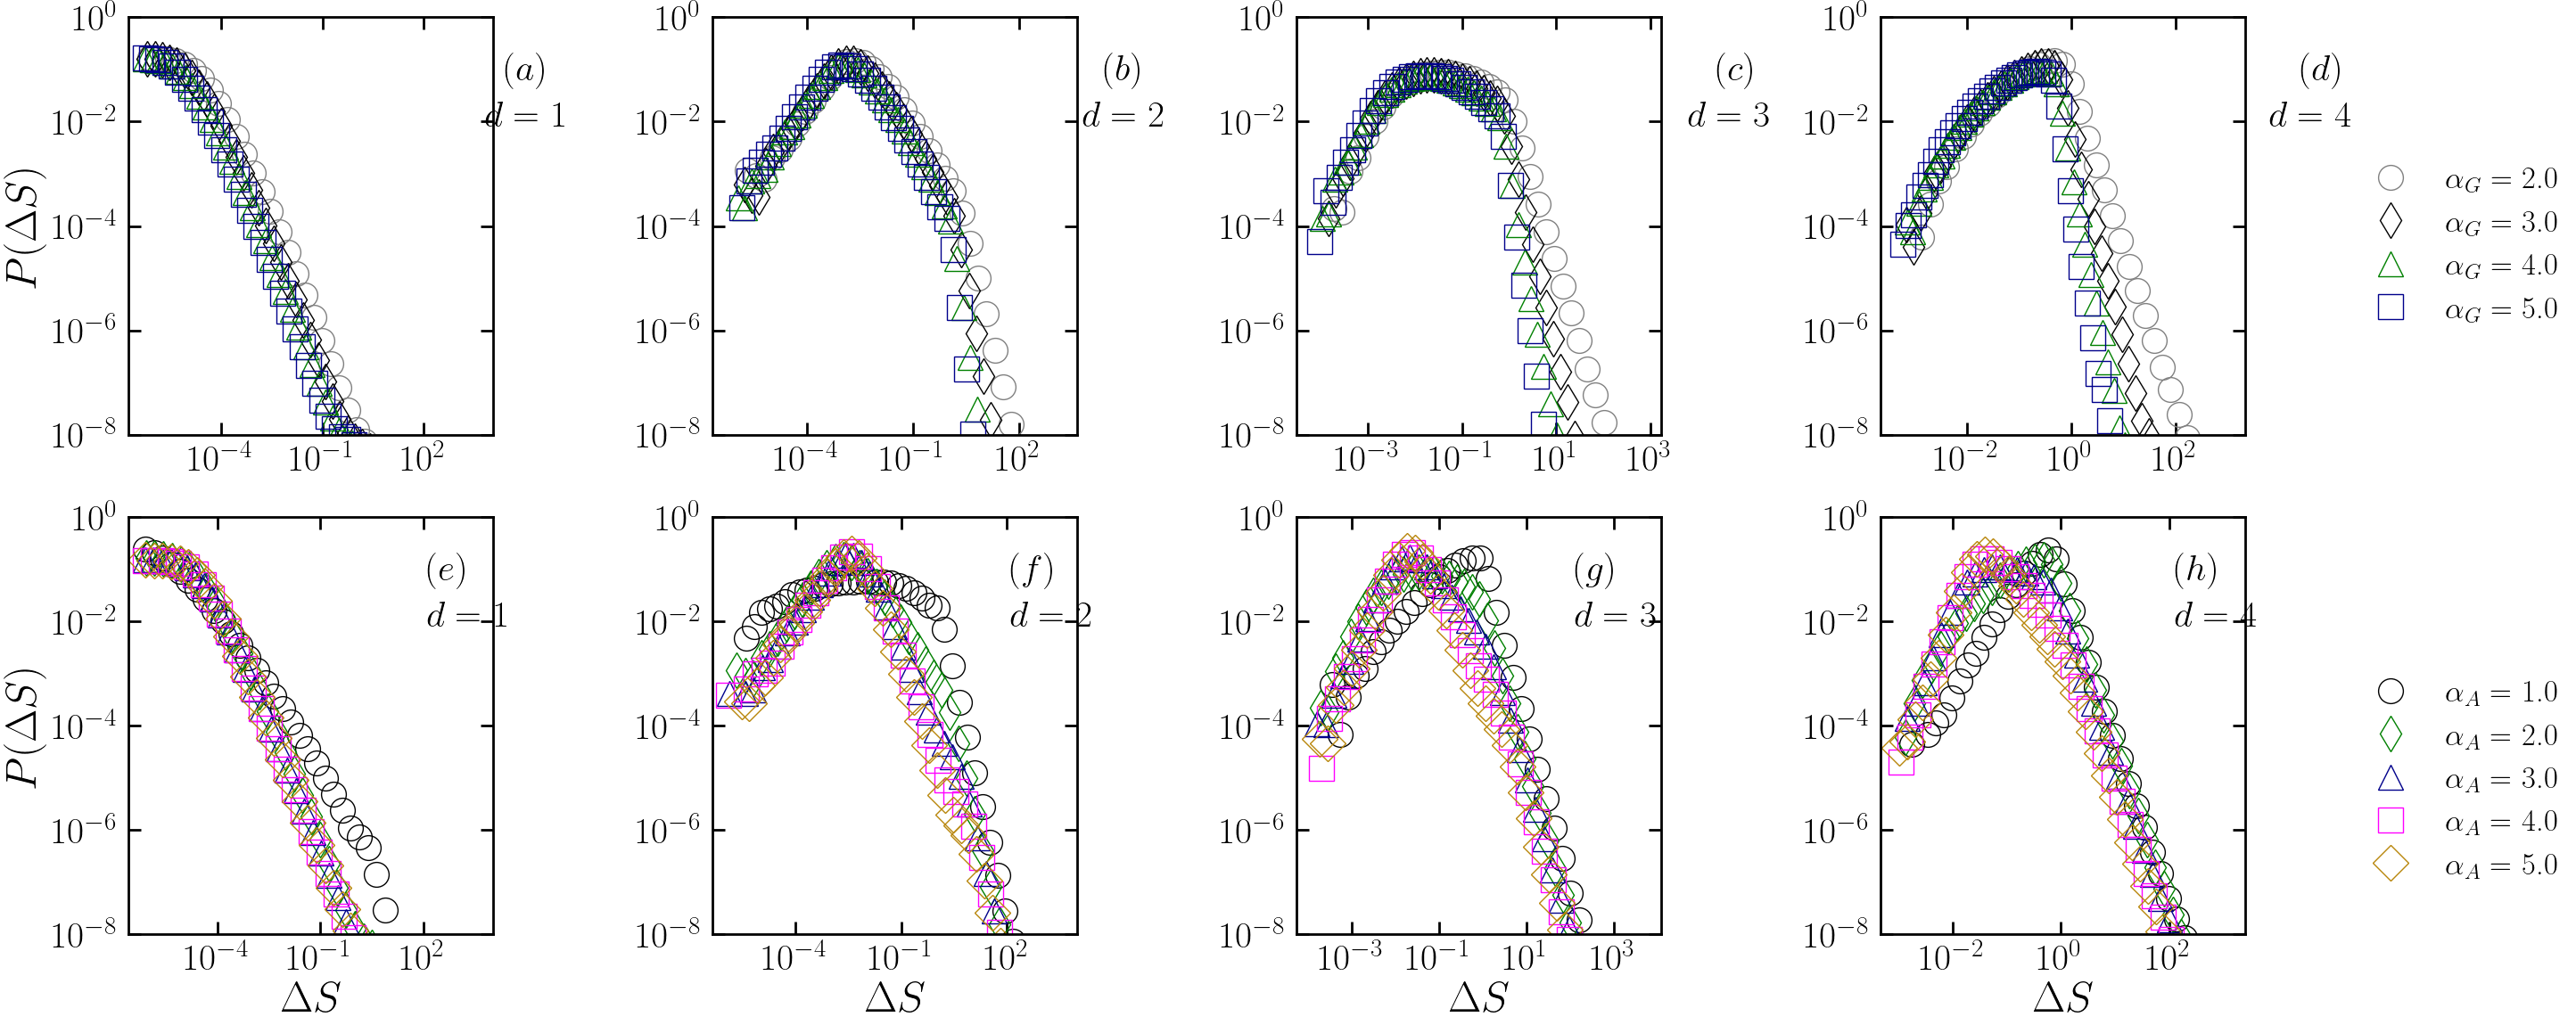

In [14]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import numpy as np

# ✔️ Parâmetros
N = 10**5
m0 = 2
dim_list = [1,2,3,4]
alpha_a_v = [1.0, 2.0, 3.0, 4.0, 5.0]
alpha_ag_f = 2.0

# ✔️ Filtrar para alpha_G fixo e alpha_A variando
df_distance_filter_alpha_a = df_distances[
    (df_distances['alpha_G'] == alpha_ag_f) &
    (df_distances['alpha_A'].isin(alpha_a_v))
]

alpha_g_v = [2.0, 3.0, 4.0, 5.0]

# ✔️ Filtrar para alpha_G fixo e alpha_A variando
df_distance_filter_alpha_g = df_distances[
    (df_distances['alpha_G'].isin(alpha_g_v)) &
    (df_distances['alpha_A'] == alpha_ag_f)
]

# ✔️ Configurações visuais
color_g = ["#808080", "black", '#008000', "#00008B", "magenta"]
color_a = ["black", '#008000', "#00008B", "magenta", "darkgoldenrod", "purple"]
markers = ["o", "d", "^", "s", "D", "v", "H", "p", "P"]
markersize = 20
thickness_axes = 2.0
font_size_labels = 35
ticks_label_size = 30

# ✔️ Textos nos subplots
dim_tick_pos_y_sup = [10**(-2.8), 10**(-2.5), 10**(-1.9), 10**(-2.3)]
labels_tick_pos_y_sup = [10**(-1.8), 10**(-1.5), 10**(-1.65), 10**(-1.3)]

dim_tick_pos_y_inf = [10**(-2.3), 10**(-1.5), 10**(-1.78), 10**(-1.60)]
labels_tick_pos_y_inf = [10**(-1.5), 10**(-1.15), 10**(-1.28), 10**(-1.10)]

dim_tick = [f"$d = {d}$" for d in dim_list]

labels_tick = ["$(a)$", "$(b)$", "$(c)$", "$(d)$", 
               "$(e)$", "$(f)$", "$(g)$", "$(h)$"]

# ✔️ Criar figura (2x4)
fig, ax = plt.subplots(2, 4, figsize=(30, 12))

# ==========================
# 🔥 PLOT SUPERIOR (Alpha_A fixo, Alpha_G variando)
# ==========================
for idx, d in enumerate(dim_list):
    row, col = 0, idx
    df_dim = df_distance_filter_alpha_g[df_distance_filter_alpha_g['dim'] == d]

    for i, alpha_g in enumerate(alpha_g_v):
        df_alpha = df_dim[df_dim['alpha_G'] == alpha_g]

        if not df_alpha.empty:
            deltaS = df_alpha['deltaS'].iloc[0]
            PdeltaS = df_alpha['pdeltaS'].iloc[0]

            ax[row, col].plot(
                deltaS, PdeltaS,
                marker=markers[i % len(markers)],
                color=color_g[i % len(color_g)],
                markersize=markersize,
                linestyle='None',
                markerfacecolor='none',
                mew=1.0,
                label="_nolegend_"
            )

    ax[row, col].text(10**4.4, 10**(-1.2), labels_tick[idx], fontsize=30)
    ax[row, col].text(10**3.8, 10**(-2.1), dim_tick[idx], fontsize=30)

    ax[row, col].set_xscale('log')
    ax[row, col].set_yscale('log')
    if(col==0):
        ax[row, col].set_ylabel(r"$P(\Delta S)$", size=font_size_labels)

    ax[row, col].tick_params(axis='both', which='major', direction='in', length=10, width=thickness_axes, labelsize=ticks_label_size)
    ax[row, col].tick_params(axis='both', which='minor', direction='in', length=7, width=thickness_axes)

    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax[row, col].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))

    ax[row, col].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))
    ax[row, col].yaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))

    for spine in ax[row, col].spines.values():
        spine.set_linewidth(thickness_axes)
    ax[row, col].set_ylim([10**(-8), 1])
# ==========================
# 🔥 PLOT INFERIOR (Alpha_G fixo, Alpha_A variando)
# ==========================
for idx, d in enumerate(dim_list):
    row, col = 1, idx
    df_dim = df_distance_filter_alpha_a[df_distance_filter_alpha_a['dim'] == d]

    for i, alpha_a in enumerate(alpha_a_v):
        df_alpha = df_dim[df_dim['alpha_A'] == alpha_a]

        if not df_alpha.empty:
            deltaS = df_alpha['deltaS'].iloc[0]
            PdeltaS = df_alpha['pdeltaS'].iloc[0]

            ax[row, col].plot(
                deltaS, PdeltaS,
                marker=markers[i % len(markers)],
                color=color_a[i % len(color_a)],
                markersize=markersize,
                linestyle='None',
                markerfacecolor='none',
                mew=1.0,
                label="_nolegend_"
            )

    ax[row, col].text(10**2.1, 10**(-1.2), labels_tick[idx + 4], fontsize=30)
    ax[row, col].text(10**2.1, 10**(-2.1), dim_tick[idx], fontsize=30)

    ax[row, col].set_xscale('log')
    ax[row, col].set_yscale('log')
    ax[row, col].set_xlabel(r"$\Delta S$", size=font_size_labels)
    if(col == 0):
        ax[row, col].set_ylabel(r"$P(\Delta S)$", size=font_size_labels)

    ax[row, col].tick_params(axis='both', which='major', direction='in', length=10, width=thickness_axes, labelsize=ticks_label_size)
    ax[row, col].tick_params(axis='both', which='minor', direction='in', length=7, width=thickness_axes)

    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, numticks=6))
    ax[row, col].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))

    ax[row, col].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))
    ax[row, col].yaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))

    for spine in ax[row, col].spines.values():
        spine.set_linewidth(thickness_axes)
    ax[row, col].set_ylim([10**(-8), 1])

# ==========================
# 🔥 Legendas globais
# ==========================

# Para o plot superior (alpha_G)
proxy_handles_alpha_g = [
    plt.Line2D([], [], color=color_g[i % len(color_g)], marker=markers[i % len(markers)],
               linestyle='None', markersize=markersize, markerfacecolor='none', mew=1.0)
    for i in range(len(alpha_g_v))
]
fig.legend(proxy_handles_alpha_g, [rf"$\alpha_G$ = {a:.1f}" for a in alpha_g_v],
           loc="center left", bbox_to_anchor=(0.88, 0.75),
           fontsize=25, frameon=False)

# Para o plot inferior (alpha_A)
proxy_handles_alpha_a = [
    plt.Line2D([], [], color=color_a[i % len(color_a)], marker=markers[i % len(markers)],
               linestyle='None', markersize=markersize, markerfacecolor='none', mew=1.0)
    for i in range(len(alpha_a_v))
]
fig.legend(proxy_handles_alpha_a, [rf"$\alpha_A$ = {a:.1f}" for a in alpha_a_v],
           loc="center left", bbox_to_anchor=(0.88, 0.25),
           fontsize=25, frameon=False)

plt.tight_layout(rect=[0, 0, 0.9, 1])
#plt.savefig("../../results/distributions/distances_distribution.svg", dpi=300)
plt.show()


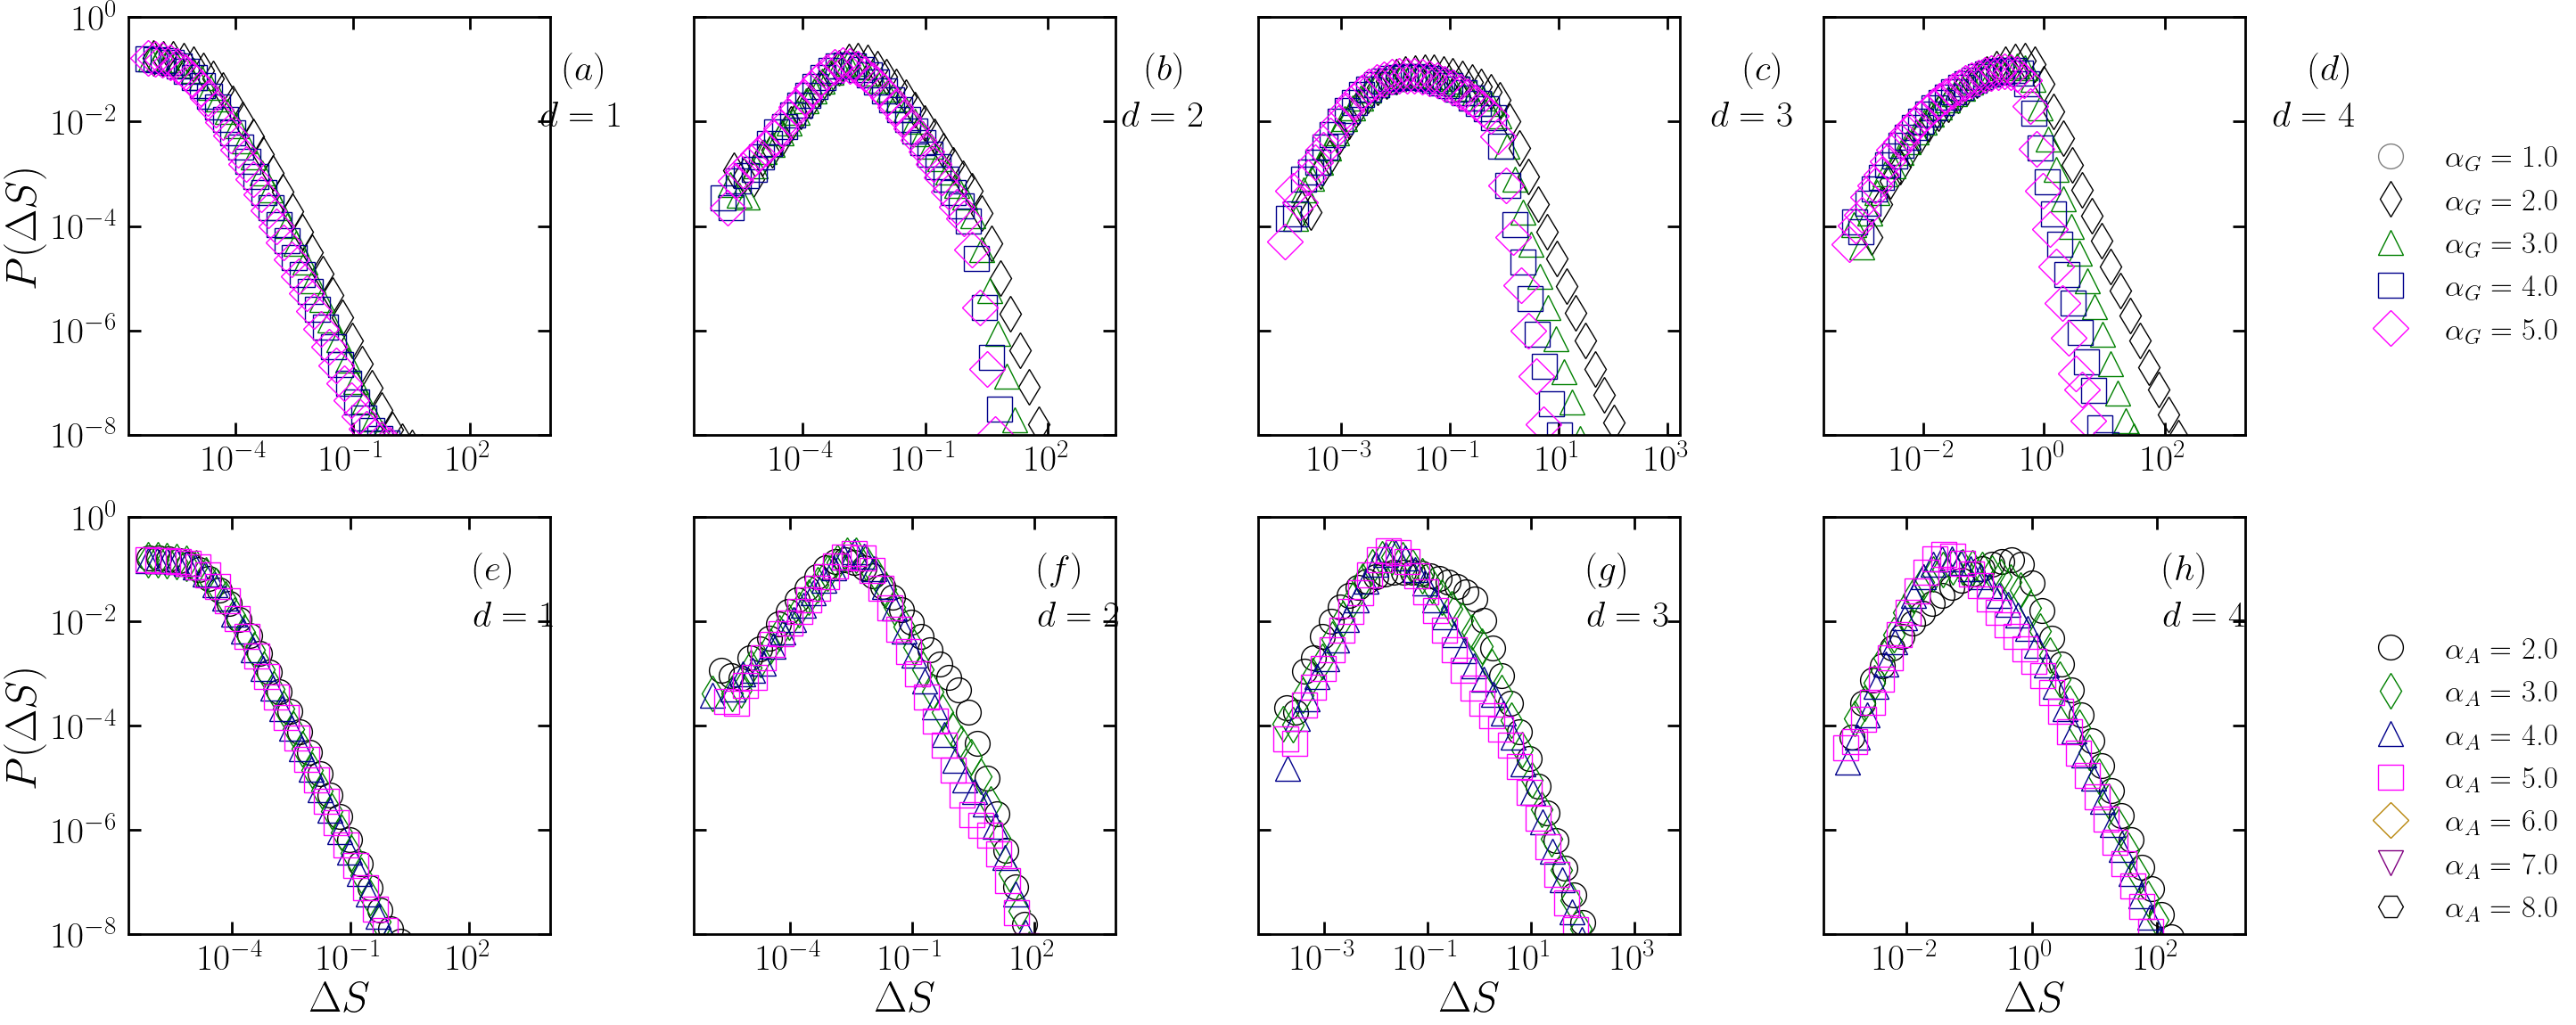

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import numpy as np

# ✔️ Parâmetros
alpha_ag_f = 2.0
alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0]
alpha_a_v = [2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
dim_list = [1, 2, 3, 4]

# ✔️ Filtrar para alpha_G fixo e alpha_A variando
df_distance_filter_alpha_a = df_distances[
    (df_distances['alpha_G'] == alpha_ag_f) &
    (df_distances['alpha_A'].isin(alpha_a_v))
]

alpha_g_v = [1.0, 2.0, 3.0, 4.0, 5.0]
dim_list = [1,2,3,4]
# ✔️ Filtrar para alpha_G fixo e alpha_A variando
df_distance_filter_alpha_g = df_distances[
    (df_distances['alpha_G'].isin(alpha_g_v)) &
    (df_distances['alpha_A'] == alpha_ag_f)
]

# ✔️ Configurações visuais
color_g = ["#808080", "black", '#008000', "#00008B", "magenta"]
color_a = ["black", '#008000', "#00008B", "magenta", "darkgoldenrod", "purple"]
markers = ["o", "d", "^", "s", "D", "v", "H", "p", "P"]
markersize = 20
thickness_axes = 2.0
font_size_labels = 35
ticks_label_size = 30

# ✔️ Textos nos subplots
dim_tick_pos_y_sup = [10**(-2.8), 10**(-2.5), 10**(-1.9), 10**(-2.3)]
labels_tick_pos_y_sup = [10**(-1.8), 10**(-1.5), 10**(-1.65), 10**(-1.3)]

dim_tick_pos_y_inf = [10**(-2.3), 10**(-1.5), 10**(-1.78), 10**(-1.60)]
labels_tick_pos_y_inf = [10**(-1.5), 10**(-1.15), 10**(-1.28), 10**(-1.10)]

dim_tick = [f"$d = {d}$" for d in dim_list]

labels_tick = ["$(a)$", "$(b)$", "$(c)$", "$(d)$", 
               "$(e)$", "$(f)$", "$(g)$", "$(h)$"]

# ✔️ Criar figura (2x4)
fig, ax = plt.subplots(2, 4, figsize=(30, 12))

# ==========================
# 🔥 PLOT SUPERIOR (Alpha_A fixo, Alpha_G variando)
# ==========================
for idx, d in enumerate(dim_list):
    row, col = 0, idx
    df_dim = df_distance_filter_alpha_g[df_distance_filter_alpha_g['dim'] == d]

    for i, alpha_g in enumerate(alpha_g_v):
        df_alpha = df_dim[df_dim['alpha_G'] == alpha_g]

        if not df_alpha.empty:
            deltaS = df_alpha['deltaS'].iloc[0]
            PdeltaS = df_alpha['pdeltaS'].iloc[0]

            ax[row, col].plot(
                deltaS, PdeltaS,
                marker=markers[i % len(markers)],
                color=color_g[i % len(color_g)],
                markersize=markersize,
                linestyle='None',
                markerfacecolor='none',
                mew=1.0,
                label="_nolegend_"
            )

    ax[row, col].text(10**4.4, 10**(-1.2), labels_tick[idx], fontsize=30)
    ax[row, col].text(10**3.8, 10**(-2.1), dim_tick[idx], fontsize=30)

    ax[row, col].set_xscale('log')
    ax[row, col].set_yscale('log')
    if(col==0):
        ax[row, col].set_ylabel(r"$P(\Delta S)$", size=font_size_labels)

    ax[row, col].tick_params(axis='both', which='major', direction='in', length=10, width=thickness_axes, labelsize=ticks_label_size)
    ax[row, col].tick_params(axis='both', which='minor', direction='in', length=7, width=thickness_axes)

    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
    ax[row, col].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))

    ax[row, col].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))

    for spine in ax[row, col].spines.values():
        spine.set_linewidth(thickness_axes)
    ax[row, col].set_ylim([10**(-8), 1])
    y_ticks = [10**(-i) for i in range(0, 9, 2)]  # 10^0, 10^-2, ..., 10^-8
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_ticks(y_ticks)
    ax[row, col].yaxis.set_major_formatter(
        LogFormatterMathtext() if col == 0 else LogFormatterMathtext(labelOnlyBase=True)
    )
    ax[row, col].tick_params(
        axis='y',
        which='both',
        direction='in',
        length=10,
        width=thickness_axes,
        labelsize=ticks_label_size,
        labelleft=(col == 0),
        left=True, right=True
    )
# ==========================
# 🔥 PLOT INFERIOR (Alpha_G fixo, Alpha_A variando)
# ==========================
for idx, d in enumerate(dim_list):
    row, col = 1, idx
    df_dim = df_distance_filter_alpha_a[df_distance_filter_alpha_a['dim'] == d]

    for i, alpha_a in enumerate(alpha_a_v):
        df_alpha = df_dim[df_dim['alpha_A'] == alpha_a]

        if not df_alpha.empty:
            deltaS = df_alpha['deltaS'].iloc[0]
            PdeltaS = df_alpha['pdeltaS'].iloc[0]

            ax[row, col].plot(
                deltaS, PdeltaS,
                marker=markers[i % len(markers)],
                color=color_a[i % len(color_a)],
                markersize=markersize,
                linestyle='None',
                markerfacecolor='none',
                mew=1.0,
                label="_nolegend_"
            )

    ax[row, col].text(10**2.1, 10**(-1.2), labels_tick[idx + 4], fontsize=30)
    ax[row, col].text(10**2.1, 10**(-2.1), dim_tick[idx], fontsize=30)

    ax[row, col].set_xscale('log')
    ax[row, col].set_yscale('log')
    ax[row, col].set_xlabel(r"$\Delta S$", size=font_size_labels)
    if(col == 0):
        ax[row, col].set_ylabel(r"$P(\Delta S)$", size=font_size_labels)

    ax[row, col].tick_params(axis='both', which='major', direction='in', length=10, width=thickness_axes, labelsize=ticks_label_size)
    ax[row, col].tick_params(axis='both', which='minor', direction='in', length=7, width=thickness_axes)

    ax[row, col].xaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
    ax[row, col].xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))

    ax[row, col].xaxis.set_major_formatter(LogFormatterSciNotation(base=10.0, labelOnlyBase=True))

    for spine in ax[row, col].spines.values():
        spine.set_linewidth(thickness_axes)
    ax[row, col].set_ylim([10**(-8), 1])
    y_ticks = [10**(-i) for i in range(0, 9, 2)]  # 10^0, 10^-2, ..., 10^-8
    ax[row, col].yaxis.set_major_locator(LogLocator(base=10.0, subs=None))
    ax[row, col].yaxis.set_minor_locator(LogLocator(base=10.0, subs='auto'))
    ax[row, col].yaxis.set_ticks(y_ticks)
    ax[row, col].yaxis.set_major_formatter(
        LogFormatterMathtext() if col == 0 else LogFormatterMathtext(labelOnlyBase=True)
    )
    ax[row, col].tick_params(
        axis='y',
        which='both',
        direction='in',
        length=10,
        width=thickness_axes,
        labelsize=ticks_label_size,
        labelleft=(col == 0),
        left=True, right=True
    )

# ==========================
# 🔥 Legendas globais
# ==========================

# Para o plot superior (alpha_G)
proxy_handles_alpha_g = [
    plt.Line2D([], [], color=color_g[i % len(color_g)], marker=markers[i % len(markers)],
               linestyle='None', markersize=markersize, markerfacecolor='none', mew=1.0)
    for i in range(len(alpha_g_v))
]
fig.legend(proxy_handles_alpha_g, [rf"$\alpha_G$ = {a:.1f}" for a in alpha_g_v],
           loc="center left", bbox_to_anchor=(0.88, 0.75),
           fontsize=25, frameon=False)

# Para o plot inferior (alpha_A)
proxy_handles_alpha_a = [
    plt.Line2D([], [], color=color_a[i % len(color_a)], marker=markers[i % len(markers)],
               linestyle='None', markersize=markersize, markerfacecolor='none', mew=1.0)
    for i in range(len(alpha_a_v))
]
fig.legend(proxy_handles_alpha_a, [rf"$\alpha_A$ = {a:.1f}" for a in alpha_a_v],
           loc="center left", bbox_to_anchor=(0.88, 0.25),
           fontsize=25, frameon=False)

plt.tight_layout(rect=[0, 0, 0.9, 1])
#plt.savefig("../../results/distributions/distances_distribution.svg", dpi=300)
plt.show()


IndexError: single positional indexer is out-of-bounds

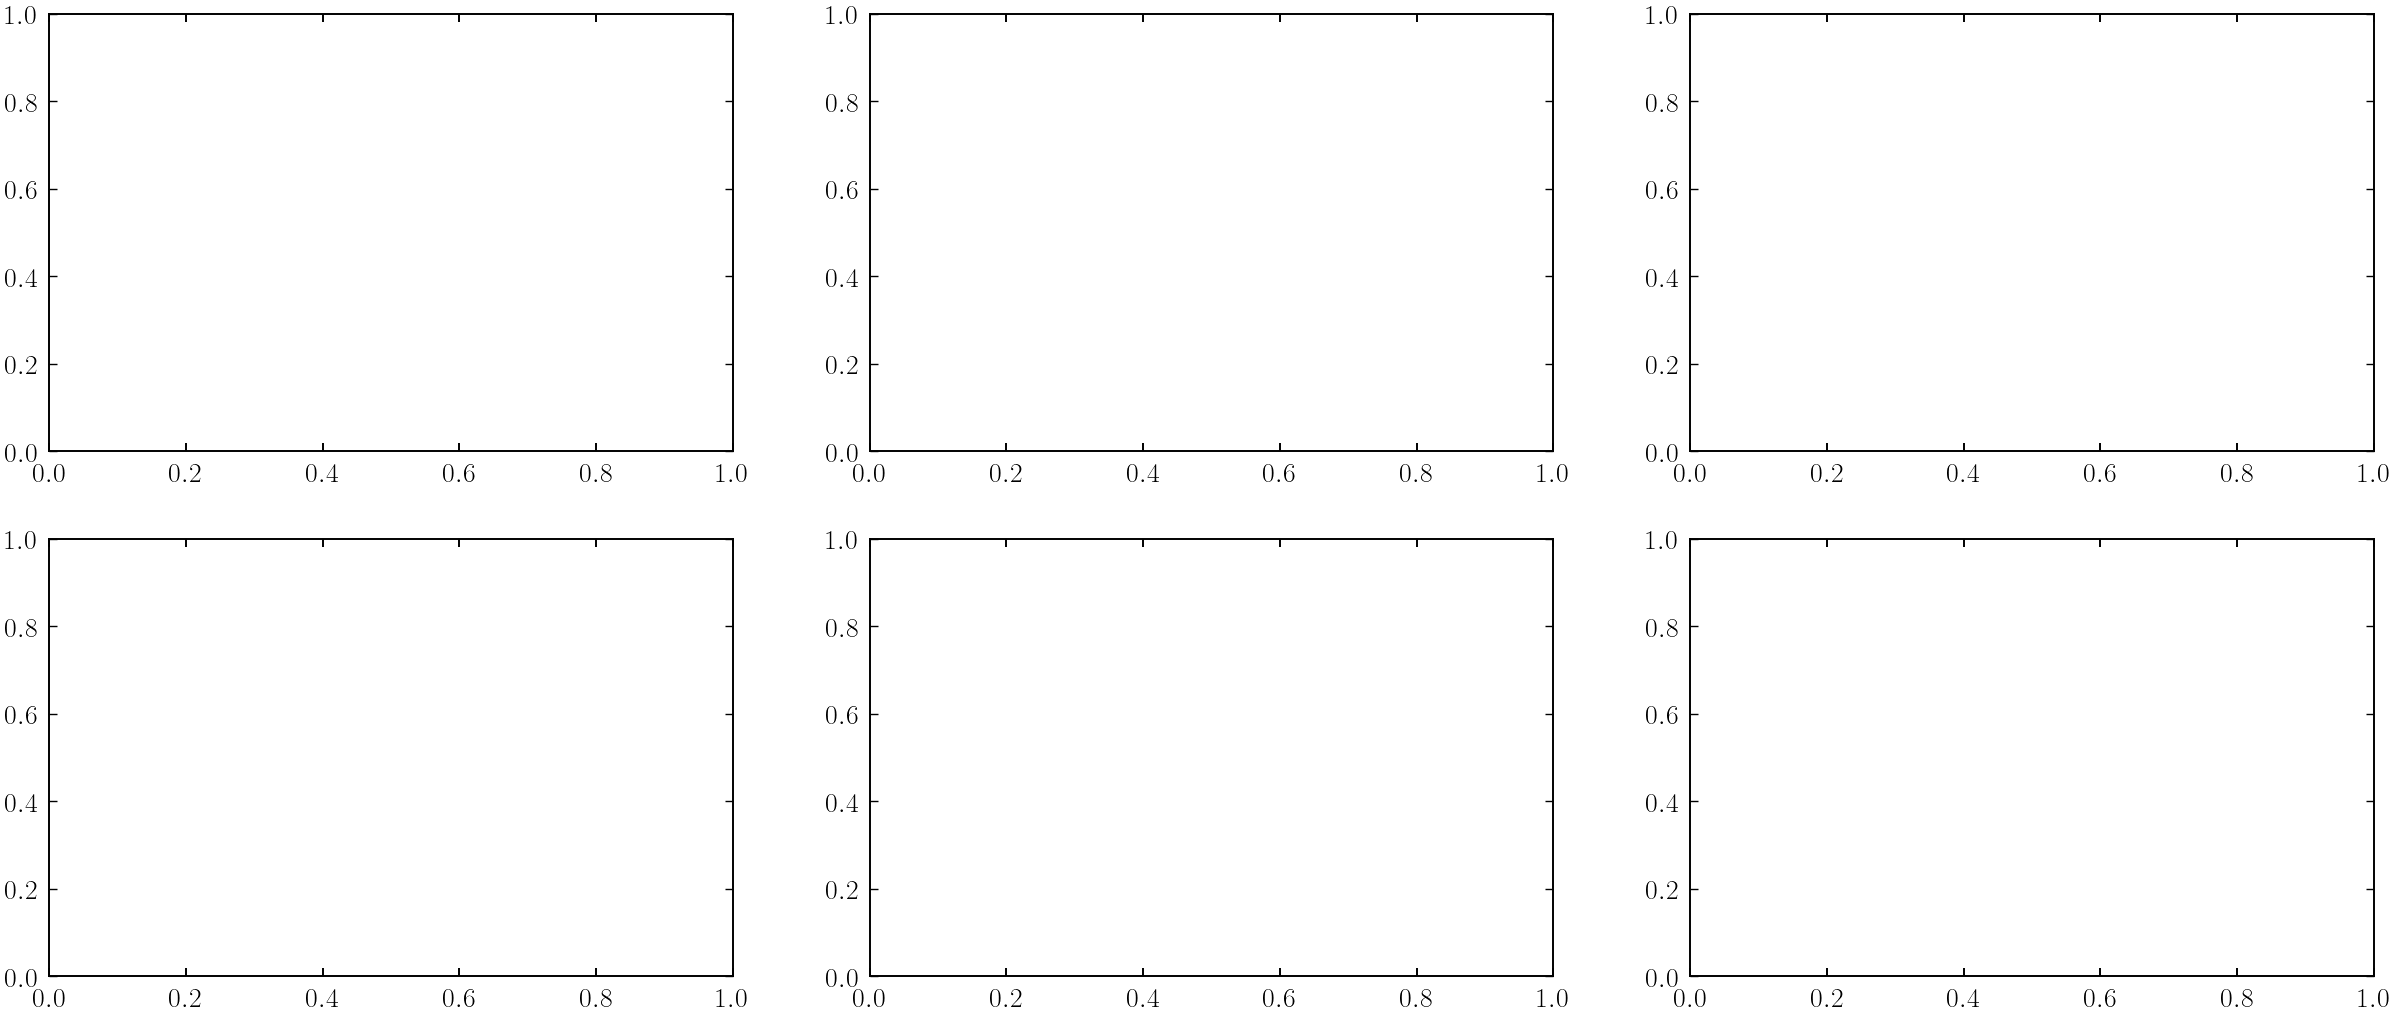

In [16]:
alpha_ag_f = 2.0

alpha_g_v = np.arange(1.0, 10, 0.5)
#alpha_a_v = np.arange(2.0, 10, 0.5)

dimensions = [2, 3, 4]

# ✔️ Filtrar para alpha_G fixo e alpha_A variando
df_distance_filter = df_distances[
    (df_distances['alpha_G'].isin(alpha_g_v)) &
    (df_distances['alpha_A'] == alpha_ag_f)
]

# Parâmetros de estilo
markersize = 20
fonts_size = 45
thickness_axes = 3.0
mew = 2.0
color = ['#008000', "#00008B", "magenta", "darkgoldenrod"]
markers = ["o", "d", "^", "s", "D"]

# Fator de escala para o eixo y
scale_factor = 1e2
scale_label = r"$\times 10^{-2}$"

dim_tick = [f"$d = {d}$" for d in dimensions]

labels_tick = ["$(a)$", "$(b)$", "$(c)$", 
               "$(d)$", "$(e)$", "$(f)$", ]


# Linha inferior: P(ΔS_max) vs α_G
fig, axs = plt.subplots(2, 3, figsize=(30, 12.5))  # antes era 12.5

for i, d in enumerate(dimensions):
    ax = axs[0, i]
    x_data, y_data = [], []
    for alpha_g in alpha_g_v:
        df_dim = df_distance_filter[df_distance_filter["dim"] == d]
        df_g = df_dim[(df_dim["alpha_G"] == alpha_g) & (df_dim["alpha_A"]==alpha_ag_f)]
        deltaS, PdeltaS = df_g["deltaS"].iloc[0], df_g["pdeltaS"].iloc[0]
        y_d = [deltaS[idx] for idx, ele in enumerate(zip(deltaS, PdeltaS)) if ele[1] == max(PdeltaS)][0]
        #y_d = max(PdeltaS)
        x_data.append(alpha_g)
        y_data.append(y_d)
    
    y_data = np.array(y_data) * scale_factor
    x_data = np.array(x_data)

    ax.plot(x_data, y_data,
            markers[i], color=color[i], markerfacecolor='None',
            markersize=markersize, mew=mew)

    #ax.set_xlabel(r"$\alpha_G$", fontsize=fonts_size)
    if i == 0:
        ax.set_ylabel(r"$\Delta S_{max}$", fontsize=fonts_size)

    y_min, y_max = y_data.min(), y_data.max()


    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.annotate(scale_label, xy=(0.0, 1.02), xycoords='axes fraction',
                fontsize=fonts_size * 0.9, ha='left', va='bottom')

    ax.tick_params(axis='both', which='major', direction='in', length=14,
                   width=thickness_axes, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=7,
                   width=thickness_axes, colors='black')
    ax.tick_params('both', labelsize=fonts_size)
    ax.yaxis.offsetText.set_fontsize(fonts_size)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    for spine in ax.spines.values():
        spine.set_linewidth(thickness_axes)
    
    yticks = ax.get_yticks()
    label_y_pos = np.mean(yticks[-2:])  # média dos dois primeiros ticks do topo
    ax.text(8, label_y_pos, labels_tick[i], fontsize=fonts_size)
    ax.text(8, label_y_pos*0.81, dim_tick[i], fontsize=fonts_size)

# Linha inferior: P(ΔS_max) vs α_G
for i, d in enumerate(dimensions):
    ax = axs[1, i]
    x_data, y_data = [], []
    for alpha_g in alpha_g_v:
        df_dim = df_distance_filter[df_distance_filter["dim"] == d]
        df_a = df_dim[(df_dim["alpha_G"] == alpha_g) & (df_dim["alpha_A"]==alpha_ag_f)]
        deltaS, PdeltaS = df_a["deltaS"], df_a["pdeltaS"].iloc[0]
        
        y_d = max(PdeltaS)
        x_data.append(alpha_g)
        y_data.append(y_d)
    
    y_data = np.array(y_data) * scale_factor
    x_data = np.array(x_data)

    ax.plot(x_data, y_data,
            markers[i], color=color[i], markerfacecolor='None',
            markersize=markersize, mew=mew)

    ax.set_xlabel(r"$\alpha_G$", fontsize=fonts_size)
    if i == 0:
        ax.set_ylabel(r"$P (\Delta S_{max})$", fontsize=fonts_size)

    y_min, y_max = y_data.min(), y_data.max()
    ax.set_yticks(np.linspace(y_min, y_max, 5))

    #ax.text(8, y_pos_pds[i], labels_tick[i + 3], fontsize=30)
    #ax.text(8, y_pos_pds[i], dim_tick[i], fontsize=30)

    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.annotate(scale_label, xy=(0.0, 1.02), xycoords='axes fraction',
                fontsize=fonts_size * 0.9, ha='left', va='bottom')

    ax.tick_params(axis='both', which='major', direction='in', length=14,
                   width=thickness_axes, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=7,
                   width=thickness_axes, colors='black')
    ax.tick_params('both', labelsize=fonts_size)
    ax.yaxis.offsetText.set_fontsize(fonts_size)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    for spine in ax.spines.values():
        spine.set_linewidth(thickness_axes)
    
    yticks = ax.get_yticks()
    label_y_pos = np.mean(yticks[-2:])  # média dos dois primeiros ticks do topo
    ax.text(8, label_y_pos, labels_tick[i+3], fontsize=fonts_size)
    ax.text(8, label_y_pos*0.81, dim_tick[i], fontsize=fonts_size)

# Ajuste de layout e salvamento
plt.tight_layout()
#plt.savefig("../../results/distributions/max_prob_dist_alpha_g.png", dpi=300)
plt.show()

In [ ]:
alpha_ag_f = 2.0

alpha_a_v = np.arange(2.0, 10, 0.5)

dimensions = [2, 3, 4]

# ✔️ Filtrar para alpha_G fixo e alpha_A variando
df_distance_filter = df_distances[
    (df_distances['alpha_G'] == alpha_ag_f) &
    (df_distances['alpha_A'].isin(alpha_a_v))
]

# Parâmetros de estilo
markersize = 20
fonts_size = 45
thickness_axes = 3.0
mew = 2.0
color = ['#008000', "#00008B", "magenta", "darkgoldenrod"]
markers = ["o", "d", "^", "s", "D"]

# Fator de escala para o eixo y
scale_factor = 1e2
scale_label = r"$\times 10^{-2}$"

dim_tick = [f"$d = {d}$" for d in dimensions]

labels_tick = ["$(a)$", "$(b)$", "$(c)$", 
               "$(d)$", "$(e)$", "$(f)$", ]

# Linha inferior: P(ΔS_max) vs α_G
fig, axs = plt.subplots(2, 3, figsize=(30, 12.5))  # 2 linhas, 3 colunas
for i, d in enumerate(dimensions):
    ax = axs[0, i]
    x_data, y_data = [], []
    for alpha_a in alpha_a_v:
        df_dim = df_distance_filter[df_distance_filter["dim"] == d]
        df_g = df_dim[(df_dim["alpha_G"] == alpha_ag_f) & (df_dim["alpha_A"]==alpha_a)]
        deltaS, PdeltaS = df_g["deltaS"].iloc[0], df_g["pdeltaS"].iloc[0]
        y_d = [deltaS[idx] for idx, ele in enumerate(zip(deltaS, PdeltaS)) if ele[1] == max(PdeltaS)][0]
        #y_d = max(PdeltaS)
        x_data.append(alpha_a)
        y_data.append(y_d)
    
    y_data = np.array(y_data) * scale_factor
    x_data = np.array(x_data)

    ax.plot(x_data, y_data,
            markers[i], color=color[i], markerfacecolor='None',
            markersize=markersize, mew=mew)

    #ax.set_xlabel(r"$\alpha_G$", fontsize=fonts_size)
    if i == 0:
        ax.set_ylabel(r"$\Delta S_{max}$", fontsize=fonts_size)

    y_min, y_max = y_data.min(), y_data.max()
    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.annotate(scale_label, xy=(0.0, 1.02), xycoords='axes fraction',
                fontsize=fonts_size * 0.9, ha='left', va='bottom')

    ax.tick_params(axis='both', which='major', direction='in', length=14,
                   width=thickness_axes, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=7,
                   width=thickness_axes, colors='black')
    ax.tick_params('both', labelsize=fonts_size)
    ax.yaxis.offsetText.set_fontsize(fonts_size)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    for spine in ax.spines.values():
        spine.set_linewidth(thickness_axes)
    
    yticks = ax.get_yticks()
    label_y_pos = np.mean(yticks[-2:])  # média dos dois primeiros ticks do topo
    if(i==0):
        label_y_pos = np.mean(yticks[:2])  # média dos dois primeiros ticks do topo
        
    ax.text(8, label_y_pos, labels_tick[i], fontsize=fonts_size)
    ax.text(8, label_y_pos*0.81, dim_tick[i], fontsize=fonts_size)

# Linha inferior: P(ΔS_max) vs α_G
for i, d in enumerate(dimensions):
    ax = axs[1, i]
    x_data, y_data = [], []
    for alpha_a in alpha_a_v:
        df_dim = df_distance_filter[df_distance_filter["dim"] == d]
        df_a = df_dim[(df_dim["alpha_G"] == alpha_ag_f) & (df_dim["alpha_A"]==alpha_a)]
        deltaS, PdeltaS = df_a["deltaS"], df_a["pdeltaS"].iloc[0]
        
        y_d = max(PdeltaS)
        x_data.append(alpha_a)
        y_data.append(y_d)
    
    y_data = np.array(y_data) * scale_factor
    x_data = np.array(x_data)

    ax.plot(x_data, y_data,
            markers[i], color=color[i], markerfacecolor='None',
            markersize=markersize, mew=mew)

    ax.set_xlabel(r"$\alpha_A$", fontsize=fonts_size)
    if i == 0:
        ax.set_ylabel(r"$P (\Delta S_{max})$", fontsize=fonts_size)

    y_min, y_max = y_data.min(), y_data.max()
    ax.set_yticks(np.linspace(y_min, y_max, 5))
    ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.annotate(scale_label, xy=(0.0, 1.02), xycoords='axes fraction',
                fontsize=fonts_size * 0.9, ha='left', va='bottom')

    ax.tick_params(axis='both', which='major', direction='in', length=14,
                   width=thickness_axes, colors='black')
    ax.tick_params(axis='both', which='minor', direction='in', length=7,
                   width=thickness_axes, colors='black')
    ax.tick_params('both', labelsize=fonts_size)
    ax.yaxis.offsetText.set_fontsize(fonts_size)

    ax.xaxis.set_major_locator(MultipleLocator(1))
    ax.xaxis.set_minor_locator(MultipleLocator(0.5))
    for spine in ax.spines.values():
        spine.set_linewidth(thickness_axes)

    yticks = ax.get_yticks()
    label_y_pos = np.mean(yticks[:2])  # média dos dois primeiros ticks do topo
    ax.text(8, label_y_pos, labels_tick[i+3], fontsize=fonts_size)
    ax.text(8, label_y_pos*0.81, dim_tick[i], fontsize=fonts_size)
# Ajuste de layout e salvamento
plt.tight_layout()
plt.savefig("../../results/distributions/max_prob_dist_alpha_a.png", dpi=300)
plt.show()